In [1]:
%matplotlib inline
import os, sys, gc
import shutil
import numpy as np
import pandas as pd
print(pd.__version__)
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import gridspec
import matplotlib.image as mpimg

from scipy.stats import pearsonr as pr

import collections


def get_model_scores(model_predictions, human_predictions):
    """Returns second best accuracy scores"""
    total = model_predictions.shape[0]

    model_guesses = np.argsort(model_predictions, axis = 1)[:, -2: ]
    model_second_guesses = model_guesses[:, 0]
    model_top_guesses = model_guesses[:, 1]
    
    human_guesses = np.argsort(human_predictions, axis = 1)[:, -2: ]
    human_second_guesses = human_guesses[:, 0]
    human_top_guesses = human_guesses[:, 1]
                                      
    matches = model_top_guesses == human_top_guesses
 
    accuracy = np.sum(matches)
    mean_accuracy = np.mean(matches)
    correct_total = accuracy
    incorrect_total = total - accuracy
   
    incorrect_sba = 0
    correct_sba = 0
    total_sba = 0
    
    for i, match in enumerate(matches):
        model_first = model_top_guesses[i]
        human_first = human_top_guesses[i]
        model_second = model_second_guesses[i]
        human_second = human_second_guesses[i]
        
        total_sba += model_second == human_second
        
        if match == True:
            correct_sba += model_second == human_second
        elif match == False:
            incorrect_sba += model_second == human_first
            
    return {'mean_accuracy': mean_accuracy, 
            'total_sba': total_sba / total, 
            'correct_sba': correct_sba / correct_total, 
            'incorrect_sba': incorrect_sba / incorrect_total}



0.20.3


In [2]:
loadDir = 'pred_scores_9k'

saveDir = 'figures'

# below---might have to redefine humans from a set ordering within saved files
# raw bins
#bins = np.load('{0}/human_bincounts.npy'.format(loadDir))
#correct = np.argmax(bins, axis = 1)
#print(correct[:5])
#raw probabilities
#humans = bins / np.sum(bins, axis = 1)[:, np.newaxis]
#max_prob = np.max(humans, axis = 1)
#humans_correct = np.argmax(humans, axis = 1)
#humans_smoothed = (bins + 1) / np.sum(bins, axis = 1)[:, np.newaxis]


#ordered_filenames = np.load('{0}/decoded_test_filename_order.npy'.format(loadDir))

labels = ['P', 'A', 'B', 'C', 'De', 'Do', 'F', 'H', 'S', 'T']

#im_dir = '/home/battleday/Academic/Berkeley/Superman/local/images/train_set_combined'

In [3]:
models = list(set([('_').join(x.split('_')[:-1]) 
          for x in os.listdir(loadDir)
          if x[-4:] == '.npz']))
print(models)

['vgg_15_BN_64', 'densenet_BC_100_12', 'resnet_preact_bottleneck_164', 'resnet_basic_110', 'shake_shake_26_2x64d_SSI_cutout16']


In [18]:
# get dataset averages
print(loadDir)
humans = []
controls = []
for model in models:
    print('')
    print(model)
    actual = pd.read_csv(loadDir + '/' + model + '_False_master_scores.csv')
    control = pd.read_csv(loadDir + '/' + model + '_True_master_scores.csv')
    #print('')
    #print('soft')
    humans_temp = actual.mean().to_frame().T
    #humans_temp['Model'] = model
    
    humans.append(humans_temp)
    #print(actual.mean().to_frame().T)
    #print('')
    #print('control')
    control_temp = control.mean().to_frame().T
    #control_temp['Model'] = model
    
    controls.append(control_temp)
    #print(control.mean().to_frame().T)
    
H = pd.concat(humans, keys = models)

H = H.drop(['c10h_train_loss', 'c10h_train_acc', 'c10h_train_c10_loss', 'c10h_train_c10_acc',
           'c10h_val_loss', 'c10h_val_acc', 'c10h_val_c10_loss',
       'c10h_val_c10_acc'], axis = 1)

columnsTitles = ['epoch', 'c10_50k_loss', 'c10_50k_acc', 'v6_loss',
       'v6_acc', 'v4_loss', 'v4_acc', 'cinic_loss',
       'cinic_acc', 'imagenet32x32_loss', 'imagenet32x32_acc']

H = H.reindex(columns=columnsTitles)
H_all = H.mean().to_frame().T 

C = pd.concat(controls, keys = models)

C = C.drop(['c10h_train_loss', 'c10h_train_acc', 'c10h_train_c10_loss', 'c10h_train_c10_acc',
           'c10h_val_loss', 'c10h_val_acc', 'c10h_val_c10_loss',
       'c10h_val_c10_acc'], axis = 1)
C = C.reindex(columns=columnsTitles)
C_all = C.mean().to_frame().T 
#print(H_all)
#print(C_all)
#print(C)
print(C.keys())
print(C_all.keys())

pred_scores_9k

vgg_15_BN_64

densenet_BC_100_12

resnet_preact_bottleneck_164

resnet_basic_110

shake_shake_26_2x64d_SSI_cutout16
Index(['epoch', 'c10_50k_loss', 'c10_50k_acc', 'v6_loss', 'v6_acc', 'v4_loss',
       'v4_acc', 'cinic_loss', 'cinic_acc', 'imagenet32x32_loss',
       'imagenet32x32_acc'],
      dtype='object')
Index(['epoch', 'c10_50k_loss', 'c10_50k_acc', 'v6_loss', 'v6_acc', 'v4_loss',
       'v4_acc', 'cinic_loss', 'cinic_acc', 'imagenet32x32_loss',
       'imagenet32x32_acc'],
      dtype='object')


['epoch', 'c10_50k_loss', 'c10_50k_acc', 'v6_loss', 'v6_acc', 'v4_loss', 'v4_acc', 'cinic_loss', 'cinic_acc', 'imagenet32x32_loss', 'imagenet32x32_acc']
['c10_50k_acc', 'v6_acc', 'v4_acc', 'cinic_acc', 'imagenet32x32_acc']
['c10_50k_loss', 'v6_loss', 'v4_loss', 'cinic_loss', 'imagenet32x32_loss']


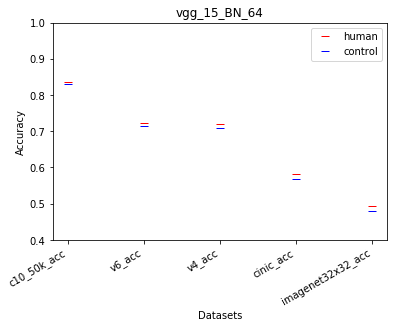

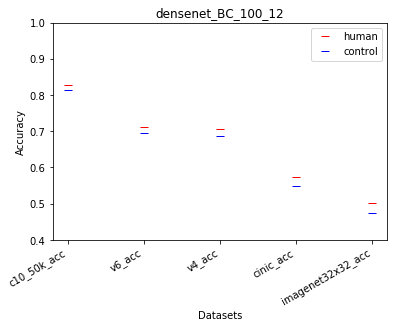

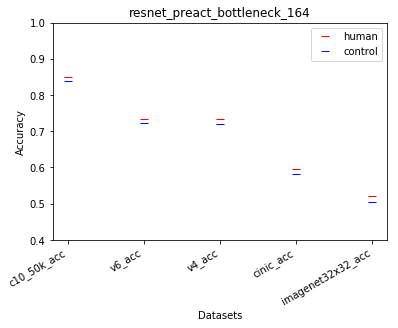

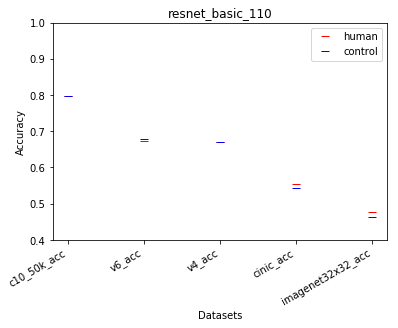

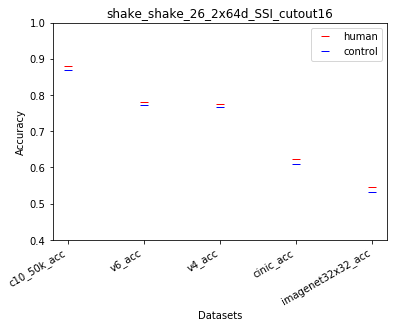

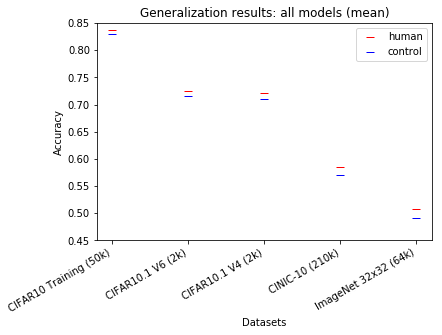

In [25]:
keys = list(C.keys())
print(keys)
accuracy_keys = [x for x in keys if 'acc' in x]
posh_accuracy_keys = ['CIFAR10 Training (50k)', 'CIFAR10.1 V6 (2k)', 'CIFAR10.1 V4 (2k)', 'CINIC-10 (210k)', 'ImageNet 32x32 (64k)']
print(accuracy_keys)
loss_keys = [x for x in keys if 'loss' in x]
print(loss_keys)

for model in models:
    plt.figure()
    human_data = H.loc[model , accuracy_keys].squeeze().as_matrix()
    control_data = C.loc[model , accuracy_keys].squeeze().as_matrix()
    plt.title(model)
    plt.ylabel('Accuracy')
    plt.xlabel('Datasets')
    plt.xticks(np.arange(human_data.shape[0]), accuracy_keys, ha='right', rotation=30)
    plt.ylim([0.4, 1])
    plt.plot(human_data, 'r', label='human', marker = '_', linewidth = 0, markersize = 8)
    plt.plot(control_data, 'b', label='control', marker = '_', linewidth = 0, markersize = 8)
    plt.legend()
    
plt.figure()
human_data = H_all.loc[:, accuracy_keys].squeeze().as_matrix()
control_data = C_all.loc[:, accuracy_keys].squeeze().as_matrix()
plt.title('Generalization results: all models (mean)')
plt.ylabel('Accuracy')
plt.xlabel('Datasets')
plt.xticks(np.arange(human_data.shape[0]), posh_accuracy_keys, ha='right', rotation=30)
plt.ylim([0.45, 0.85])
plt.plot(human_data, 'r', label='human', marker = '_', linewidth = 0, markersize = 8)
plt.plot(control_data, 'b', label='control', marker = '_', linewidth = 0, markersize = 8) 
plt.legend()

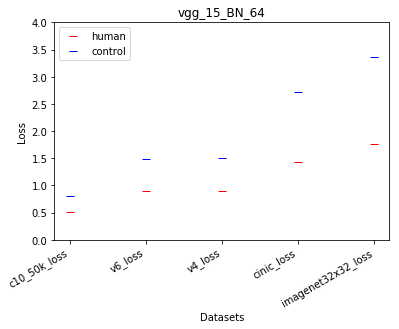

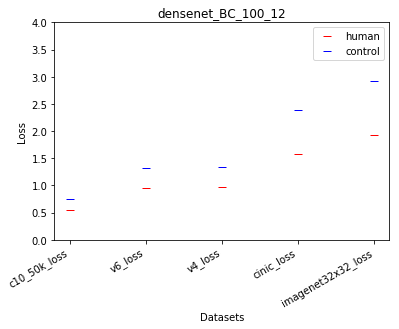

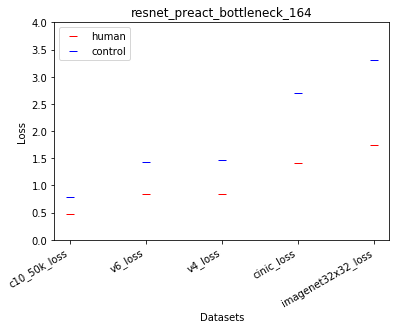

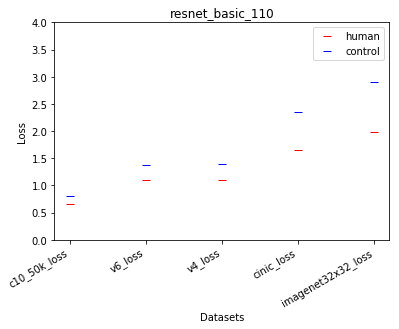

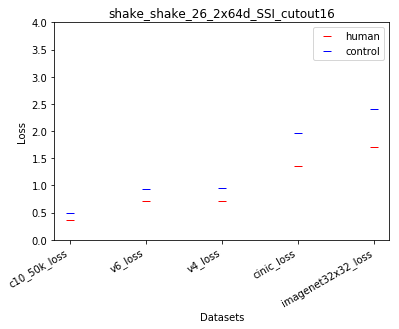

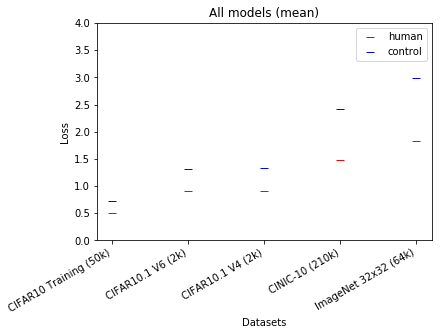

In [24]:
for model in models:
    plt.figure()
    human_data = H.loc[model , loss_keys].squeeze().as_matrix()
    control_data = C.loc[model , loss_keys].squeeze().as_matrix()
    plt.title(model)
    plt.ylabel('Loss')
    plt.xlabel('Datasets')
    plt.xticks(np.arange(human_data.shape[0]), loss_keys, ha='right', rotation=30)
    plt.ylim([0, 4])
    plt.plot(human_data, 'r', label='human', marker = '_', linewidth = 0, markersize = 8)
    plt.plot(control_data, 'b', label='control', marker = '_', linewidth = 0, markersize = 8)
    plt.legend()
    
plt.figure()
human_data = H_all.loc[:, loss_keys].squeeze().as_matrix()
control_data = C_all.loc[:, loss_keys].squeeze().as_matrix()
plt.title('All models (mean)')
plt.ylabel('Loss')
plt.xlabel('Datasets')
plt.xticks(np.arange(human_data.shape[0]), posh_accuracy_keys, ha='right', rotation=30)
plt.ylim([0, 4])
plt.plot(human_data, 'r', label='human', marker = '_', linewidth = 0, markersize = 8)
plt.plot(control_data, 'b', label='control', marker = '_', linewidth = 0, markersize = 8) 
plt.legend()

In [9]:
human_files = [x + '_False.npz' for x in models]
print(human_files)
#test_files = sort(human)
#print(test_files)
#test_files.remove('resnet_preact_bottleneck_164_test.npz')
#print(test_files)

human_dict = collections.OrderedDict()
for m in human_files:
    raw = np.load('{0}/{1}'.format(loadDir, m))
    model = m.split('.')[0]
    human_dict[model] = {}
    for prop in raw.keys(): 
        human_dict[model][prop] = raw[prop]
print(human_dict.keys())

['vgg_15_BN_64_False.npz', 'densenet_BC_100_12_False.npz', 'resnet_preact_bottleneck_164_False.npz', 'resnet_basic_110_False.npz', 'shake_shake_26_2x64d_SSI_cutout16_False.npz']
odict_keys(['vgg_15_BN_64_False', 'densenet_BC_100_12_False', 'resnet_preact_bottleneck_164_False', 'resnet_basic_110_False', 'shake_shake_26_2x64d_SSI_cutout16_False'])


In [10]:
control_files = [x + '_True.npz' for x in models]
print(control_files)
#test_files = sort(control)
#print(test_files)
#test_files.remove('resnet_preact_bottleneck_164_test.npz')
#print(test_files)

control_dict = collections.OrderedDict()
for m in control_files:
    raw = np.load('{0}/{1}'.format(loadDir, m))
    model = m.split('.')[0]
    control_dict[model] = {}
    for prop in raw.keys(): 
        control_dict[model][prop] = raw[prop]
print(control_dict.keys())

['vgg_15_BN_64_True.npz', 'densenet_BC_100_12_True.npz', 'resnet_preact_bottleneck_164_True.npz', 'resnet_basic_110_True.npz', 'shake_shake_26_2x64d_SSI_cutout16_True.npz']
odict_keys(['vgg_15_BN_64_True', 'densenet_BC_100_12_True', 'resnet_preact_bottleneck_164_True', 'resnet_basic_110_True', 'shake_shake_26_2x64d_SSI_cutout16_True'])


In [11]:
accuracies = []
sbas = []
i_sbas = []
c_sbas = []


for model, value in human_dict.items():
    print(model)

    humans = value['labels']
    print(humans.shape)
    humans_val = humans.copy()
    print(humans_val.shape)
    model_val = value['probs']
    print(model_val.shape)
    value['scores'] = get_model_scores(model_val, 
                                       humans_val)
    for k, v in value['scores'].items():
        print(k, v)
        
    accuracies.append(value['scores']['mean_accuracy'])
    sbas.append(value['scores']['total_sba'])
    i_sbas.append(value['scores']['incorrect_sba'])
    c_sbas.append(value['scores']['correct_sba'])
    


vgg_15_BN_64_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8433
total_sba 0.2747
correct_sba 0.313411597296
incorrect_sba 0.5794511806
densenet_BC_100_12_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8346
total_sba 0.257
correct_sba 0.292954708843
incorrect_sba 0.572551390568
resnet_preact_bottleneck_164_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8544
total_sba 0.2686
correct_sba 0.30079588015
incorrect_sba 0.585851648352
resnet_basic_110_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8056
total_sba 0.2509
correct_sba 0.293073485601
incorrect_sba 0.54012345679
shake_shake_26_2x64d_SSI_cutout16_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.887
total_sba 0.27
correct_sba 0.294926719278
incorrect_sba 0.599115044248


In [12]:
accuracies_post = []
sbas_post = []
i_sbas_post = []
c_sbas_post = []

for model, value in control_dict.items():
    print(model)

    humans = value['labels']
    print(humans.shape)
    
    humans_val = humans.copy()
    print(humans_val.shape)
    model_val = value['probs']
    print(model_val.shape)
    value['scores'] = get_model_scores(model_val, 
                                       humans_val)
    for k, v in value['scores'].items():
        print(k, v)
        
    accuracies_post.append(value['scores']['mean_accuracy'])
    sbas_post.append(value['scores']['total_sba'])
    i_sbas_post.append(value['scores']['incorrect_sba'])
    c_sbas_post.append(value['scores']['correct_sba'])

vgg_15_BN_64_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.84
total_sba 0.2165
correct_sba 0.243095238095
incorrect_sba 0.549375
densenet_BC_100_12_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8273
total_sba 0.2218
correct_sba 0.251299407712
incorrect_sba 0.568616097279
resnet_preact_bottleneck_164_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8429
total_sba 0.2208
correct_sba 0.24795349389
incorrect_sba 0.58179503501
resnet_basic_110_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8017
total_sba 0.1957
correct_sba 0.228140202071
incorrect_sba 0.534543620777
shake_shake_26_2x64d_SSI_cutout16_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8754
total_sba 0.2421
correct_sba 0.267649074709
incorrect_sba 0.607544141252


['vgg_15_BN_64', 'densenet_BC_100_12', 'resnet_preact_bottleneck_164', 'resnet_basic_110', 'shake_shake_26_2x64d_SSI_cutout16']
5 5


0.0070437652482155501

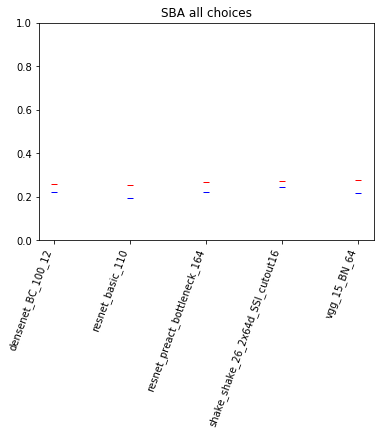

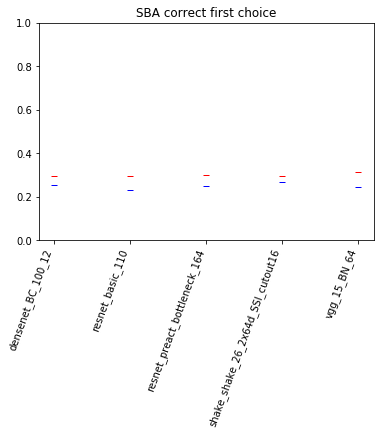

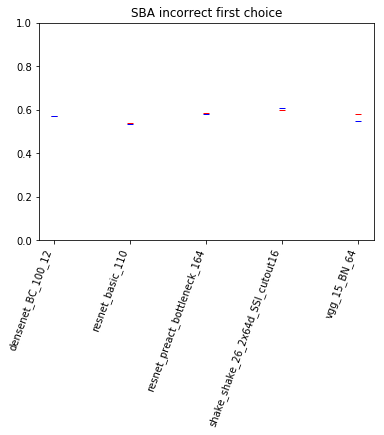

In [14]:
models_new = models.copy()
print(models_new)
print(len(models_new), len(accuracies))

plt.figure()
plt.title('SBA all choices')
plt.ylim([0, 1])
plt.plot(models_new, sbas, 'r', marker='_', linewidth=0)
plt.plot(models_new, sbas_post, 'b', marker='_', linewidth=0)
plt.xticks(rotation=70, ha='right')
np.mean(np.array(sbas) - np.array(sbas_post))

plt.figure()
plt.title('SBA correct first choice')
plt.ylim([0, 1])
plt.plot(models_new, c_sbas, 'r', marker='_', linewidth=0)
plt.plot(models_new, c_sbas_post, 'b', marker='_', linewidth=0)
plt.xticks(rotation=70, ha='right')

np.mean(np.array(c_sbas) - np.array(c_sbas_post))

plt.figure()
plt.title('SBA incorrect first choice')
plt.ylim([0, 1])
plt.plot(models_new, i_sbas, 'r', marker='_', linewidth=0)
plt.plot(models_new, i_sbas_post, 'b', marker='_', linewidth=0)
plt.xticks(rotation=70, ha='right')
np.mean(np.array(i_sbas) - np.array(i_sbas_post))